In [1]:
""" Fit a pair potential such that 2-centre tight binding can reproduce the energy of a Si trimer
    (Contrived example to keep things as simple as possible)
"""

' Fit a pair potential such that 2-centre tight binding can reproduce the energy of a Si trimer\n    (Contrived example to keep things as simple as possible)\n'

In [2]:
import os
import pathlib
from types import SimpleNamespace

import matplotlib.pyplot as plt

import plato_pylib.shared.ucell_class as UCell
import plato_pylib.plato.mod_plato_inp_files as modInp
import plato_pylib.utils.job_running_functs as jobRun
import plato_pylib.plato.parse_plato_out_files as parsePlato
import plato_pylib.plato.parse_tbint_files as parseTbint

import plato_fit_integrals.core.workflow_coordinator as wFlow
import plato_fit_integrals.core.obj_funct_calculator as objFunctCalc
import plato_fit_integrals.core.create_analytical_reprs as analyticFuncts
import plato_fit_integrals.core.coeffs_to_tables as coeffsToTables
import plato_fit_integrals.core.opt_runner as optRunner

import plato_fit_integrals.initialise.fit_analytic_to_initial_tables as fitInit


#Relative path passed to plato in "dataset" keyword
MODEL_DATAFOLDER = "Test/format_4"
FULL_PATH_MODEL_DATAFOLDER = modInp.getAbsolutePathForPlatoTightBindingDataSet(MODEL_DATAFOLDER)

WORK_FOLDER = os.path.abspath("work_folder")
ATOM_SYMBOL = "Si"
N_CORES = 1
ENERGY_PROP_STR = "trimerEnergy"

#TODO: Will pull these parameters directly from the relevant files;
R_CUT = 12.0
REF_R0 = 1.0
VAL_AT_REF_R0 = 16.71882743
N_POLY = 3
TAIL_DELTA = 0.5


In [5]:
#Create Trimer geometry
def createTrimerGeometry(atomSymbol):
    boxLength = 50
    lattVects = [ [boxLength, 0.0      , 0.0      ],
                  [0.0      , boxLength, 0.0      ],
                  [0.0      , 0.0      , boxLength] ]
    
    fractCoords = [[0.5, 0.5, 0.46,  atomSymbol],
                   [0.5, 0.5, 0.54,  atomSymbol],
                   [0.5, 0.5992156741649222, 0.5275, atomSymbol]]
    
    outGeom = UCell.UnitCell.fromLattVects(lattVects, fractCoords=fractCoords)
    return outGeom
    


In [6]:
#Get a dictionary representing plato dft2 file for the trimer of interest
def getRefDft2Dict(atomSymbol):
    dft2FileDict = modInp.getDefOptDict("dft2")
    dft2FileDict["integralmeshspacing"] = [50,50,50]
    dft2FileDict["dataset"] = MODEL_DATAFOLDER
    outDict = modInp.getStrDictFromOptDict(dft2FileDict,"dft2")
    geomSection = modInp.getPlatoGeomDictFromUnitCell( createTrimerGeometry(atomSymbol) )
    outDict.update(geomSection)
    return outDict


In [7]:
# Create a workflow object, when run() is called it needs to populate the required fields
class WorkFlowTrimerEnergyTwoBodyTB(wFlow.WorkFlowBase):
    
    def __init__(self):
        pass #Everything is hard-coded into this class

    @property
    def namespaceAttrs(self):
        return [ENERGY_PROP_STR]
    
    @property
    def workFolder(self):
        return WORK_FOLDER
    
    def run(self):
        #Create file
        inpPath = os.path.join(self.workFolder,"trimer_tb1_calc.in")
        outDict = getTrimerOutDictTb1Calc(ATOM_SYMBOL)
        modInp.writePlatoOutFileFromDict(inpPath,outDict)
        
        #Run calc
        runComms = jobRun.pathListToPlatoRunComms([inpPath],"tb1")
        jobRun.executeRunCommsParralel(runComms,1,quiet=True)

        #Get energy and clean up
        outPath = inpPath.replace(".in",".out")
        cohesiveE = parsePlato.parsePlatoOutFile(outPath)["energies"].electronicCohesiveE
        self.output = SimpleNamespace(trimerEnergy=cohesiveE)
        os.remove(outPath)
    
def getTrimerOutDictTb1Calc(atomSymbol):
    #Create the input file
    tb1FileDict = modInp.getDefOptDict("tb1")
    tb1FileDict["dataset"] = MODEL_DATAFOLDER
    tb1FileDict["addcorrectingppfrombdt"] = 1
    outDict = modInp.getStrDictFromOptDict(tb1FileDict,"tb1")
    outDict["cellrepeat"] = "0 0 0"
    geomSection = modInp.getPlatoGeomDictFromUnitCell( createTrimerGeometry(atomSymbol) )
    outDict.update(geomSection)
    return outDict





In [8]:
# Create a folder to do all calculations in 
pathlib.Path(WORK_FOLDER).mkdir(exist_ok=True,parents=True)

In [9]:
#Step 1 is to generate the reference cohesive energy from dft2 (which accounts for all 3-b effects)

#write the input file
refFileDict = getRefDft2Dict(ATOM_SYMBOL)
refOutPath = os.path.join(WORK_FOLDER, "ref_trimer.in")
modInp.writePlatoOutFileFromDict(refOutPath, refFileDict)

#Run the job
runComms = jobRun.pathListToPlatoRunComms([refOutPath],"dft2")
#jobRun.executeRunCommsParralel(runComms,N_CORES)

#Get the energy out
REF_COH_ENERGY = parsePlato.parsePlatoOutFile(refOutPath.replace(".in",".out"))["energies"].electronicCohesiveE

print("The reference energy is {} Ry".format(REF_COH_ENERGY))

The reference energy is -0.8449983 Ry


In [10]:
#Step 2 = Create a workflow co-ordinator to run all jobs and parse all outputs during the optimisation
workflowCoordinator = wFlow.WorkFlowCoordinator( [WorkFlowTrimerEnergyTwoBodyTB()] )



In [11]:
#Step 3 = Define the objective function to use, in terms of properties for which one of the workflows can calculate
# This turns calculated properties into a value which we want to minimise
def createSqrDevObjFunct():
    def objFunct(targ,val):
        try:
            outVal = (targ-val)**2
        except OverflowError:
            outVal = 1e30
        return outVal
    return objFunct

singlePropObjFunct = createSqrDevObjFunct()
propsWithObjFunct = SimpleNamespace( **{ENERGY_PROP_STR:(REF_COH_ENERGY,singlePropObjFunct)} )

objFunctCalculator = objFunctCalc.ObjectiveFunctionContrib(propsWithObjFunct)

In [12]:
#Step 4 = Attach an analytical functional form to each integral that we fit

ppAnalyticFunct = analyticFuncts.Cawkwell17ModTailRepr(rCut=R_CUT, refR0=REF_R0, valAtR0=VAL_AT_REF_R0,
                                                       tailDelta=TAIL_DELTA, nPoly=N_POLY)

integralInfo = coeffsToTables.IntegralTableInfo(FULL_PATH_MODEL_DATAFOLDER, "pairPot", atomA=ATOM_SYMBOL, atomB=ATOM_SYMBOL)
startTables = parseTbint.getIntegralsFromBdt(integralInfo.filePath)
integHolder = coeffsToTables.IntegralsHolder( [(ATOM_SYMBOL,ATOM_SYMBOL)], [startTables])

#Need to attach the node-values to our analytical repr
startData = integHolder.getIntegTable("pairPot", ATOM_SYMBOL, ATOM_SYMBOL, inclCorrs=False)
nodeValues = fitInit.find_crossings(startData.integrals[:,0],startData.integrals[:,1])
ppAnalyticFunct.nodePositions = nodeValues

coeffsTablesConverter = coeffsToTables.CoeffsTablesConverter([ppAnalyticFunct], [integralInfo], integHolder)

The value of key = xtalfieldxc
The value of key = pairpot
The value of key = xtalfieldtotal
The value of key = hopping
The value of key = xtalfieldnoxc
The value of key = pairpotcorrection0
The value of key = overlap
keys are dict_keys(['nonlocpp', 'pairpotcorrection0', 'nijints', 'kinetic', 'pairfunct', 'hopxccontrib', 'pairpot', 'crystalfieldnonxc', 'hopping', 'hop3b2c', 'snints', 'crystalfieldxc', 'hopcorrection0', 'overlap', 'crystalfieldtotal'])


In [13]:
#Step 5 = Get the initial parameters to represent our integrals, we do this by fitting to the starting tabulated values
fitInit.fitAnalyticFormToStartIntegrals(coeffsTablesConverter, intIdx=0)


      fun: 0.024421334914897203
 hess_inv: array([[ 2.83263666, -3.57989369,  0.71796388],
       [-3.57989369,  5.34034254, -1.13928388],
       [ 0.71796388, -1.13928388,  0.26664719]])
      jac: array([-9.07341018e-07, -6.92438334e-07,  1.49407424e-06])
  message: 'Optimization terminated successfully.'
     nfev: 370
      nit: 44
     njev: 74
   status: 0
  success: True
        x: array([-0.99325739,  0.01197981, -0.00872202])

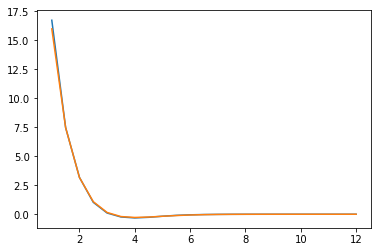

In [14]:
#Step 7 = Check out well we fit our initial values
fittedData = integHolder.getIntegTable("pairPot", ATOM_SYMBOL, ATOM_SYMBOL)

figA = plt.figure()
ax1 = figA.add_subplot(1,1,1)
ax1.plot(startData.integrals[:,0], startData.integrals[:,1])
ax1.plot(fittedData.integrals[:,0], fittedData.integrals[:,1])


In [15]:
#Step 8 = Run the actual optimisation
objFunct = optRunner.ObjectiveFunction(coeffsTablesConverter, workflowCoordinator, objFunctCalculator)
optRunner.carryOutOptimisationBasicOptions(objFunct)


      fun: 9.000000003848271e-14
 hess_inv: array([[ 0.0762504 , -0.00773479, -0.00269103],
       [-0.00773479,  0.94270974, -0.23534333],
       [-0.00269103, -0.23534333,  0.05962277]])
      jac: array([0.00000000e+00, 4.69762048e-06, 2.68435456e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 452
      nit: 3
     njev: 88
   status: 2
  success: False
        x: array([-0.99308452,  0.0119606 , -0.00880744])

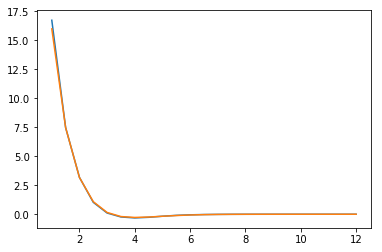

In [17]:
#Plot the new funcitonal form (which should be nearly unchanged)
fittedData = integHolder.getIntegTable("pairPot", ATOM_SYMBOL, ATOM_SYMBOL)

figA = plt.figure()
ax1 = figA.add_subplot(1,1,1)
ax1.plot(startData.integrals[:,0], startData.integrals[:,1])
ax1.plot(fittedData.integrals[:,0], fittedData.integrals[:,1])
